# Lecture 14 - Kerr nonlinearities

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
from base64 import b64encode

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation
from qutip import (about, coherent, destroy, expect, isket, ket2dm, mesolve,
                   num, variance, wigner)

%matplotlib inline

## Introduction

The Kerr effect describes a self-interaction electromagnetic quantum field which occur in a nonlinear medium. A single mode of the quantum field can be described by the effective Hamiltonian

$\displaystyle H = \frac{1}{2}\chi (a^\dagger)^2a^2$

where $\chi$ is related to the third-order nonlinear susceptibility. The Kerr effect is one of the typical nonlinearities that can occur in quantum optics due to a nonlinear medium.

In this notebook we'll see how to setup the model in QuTiP and look at some interesting properties of the states that evolve according to this Hamiltonian.

## Parameters

In [2]:
N = 15
chi = 1 * 2 * np.pi  # Kerr-nonlinearity
tlist = np.linspace(0, 1.0, 51)  # time

In [3]:
# operators: the annihilation operator of the field
a = destroy(N)

# and we'll also need the following operators in calculation of
# expectation values when visualizing the dynamics
n = num(N)
x = a + a.dag()
p = -1j * (a - a.dag())

In [4]:
# the Kerr Hamiltonian
H = 0.5 * chi * a.dag() * a.dag() * a * a

## Functions for plotting

We start by defining some function for visualizing the dynamics. We'll use these further down in the notebook. 

In [5]:
def plot_expect_with_variance(N, op_list, op_title, states):
    """
    Plot the expectation value of an operator (list of operators)
    with an envelope that describes the operators variance.
    """

    fig, axes = plt.subplots(1, len(op_list), figsize=(14, 3))

    for idx, op in enumerate(op_list):

        e_op = expect(op, states)
        v_op = variance(op, states)

        axes[idx].fill_between(
            tlist, e_op - np.sqrt(v_op), e_op + np.sqrt(v_op), color="green",
            alpha=0.5
        )
        axes[idx].plot(tlist, e_op)
        axes[idx].set_xlabel("Time")
        axes[idx].set_title(op_title[idx])
        axes[idx].set_xlim(0, max(tlist))

    return fig, axes

In [6]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density
    matrix for a harmonic oscillator mode.
    """

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if isket(rho):
        rho = ket2dm(rho)

    xvec = np.linspace(-7.5, 7.5, 200)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(
        xvec,
        xvec,
        W,
        100,
        norm=mpl.colors.Normalize(-wlim, wlim),
        cmap=mpl.cm.get_cmap("RdBu"),
    )
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)

    return fig, ax

In [7]:
def plot_fock_distribution_vs_time(tlist, states, fig=None, ax=None):

    Z = np.zeros((len(tlist), states[0].shape[0]))

    for state_idx, state in enumerate(states):
        Z[state_idx, :] = np.real(ket2dm(state).diag())

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    Y, X = np.meshgrid(tlist, range(states[0].shape[0]))
    p = ax.pcolor(
        X,
        Y,
        Z.T,
        norm=mpl.colors.Normalize(0, 0.5),
        cmap=mpl.cm.get_cmap("Reds"),
        edgecolors="k",
    )
    ax.set_xlabel(r"$N$", fontsize=16)
    ax.set_ylabel(r"$t$", fontsize=16)

    cb = fig.colorbar(p)
    cb.set_label("Probability")

    return fig, ax

In [8]:
def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" \
                src="data:video/x-m4v;base64,{0}">'.format(
        video_encoded
    )
    return HTML(video_tag)

## Coherent state

Let's look at how the coherent state evolves under the influence of the Kerr Hamiltonian.

In [9]:
# we start with a coherent state with alpha=2.0
psi0 = coherent(N, 2.0)

In [10]:
# and evolve the state under the influence of the hamiltonian.
# by passing an empty list as expectation value operators argument,
# we get the full state of the system in result.states
result = mesolve(H, psi0, tlist, [], [])

First, let's look at how the expectation values and variances of the photon number operator $n$ and the $x$ and $p$ quadratures evolve in time:

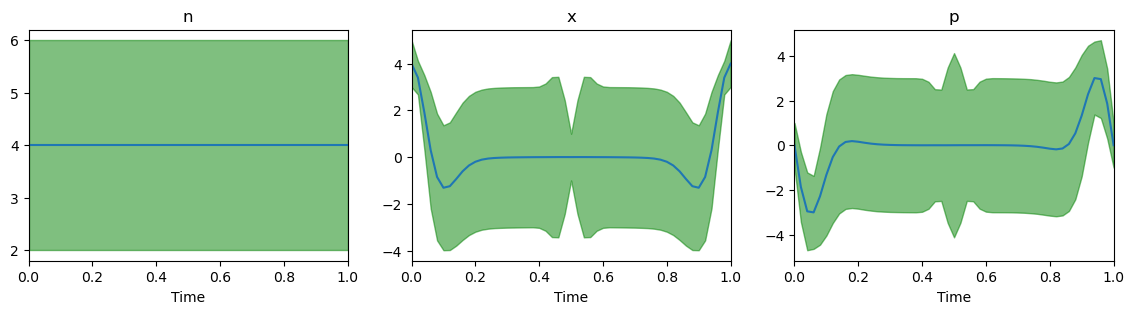

In [11]:
plot_expect_with_variance(N, [n, x, p], [r"n", r"x", r"p"], result.states);

Note that the average photon number $\langle n \rangle$ and the corresponding variance is constant, suggesting that the Fock state distribution is preserved. From the plots above we can also see that during the evolution the variance in $x$ and $p$ change as a function of time. 

To verify that the photon distribution indeed is time-independent, we can plot the fock distribution as a function of time:

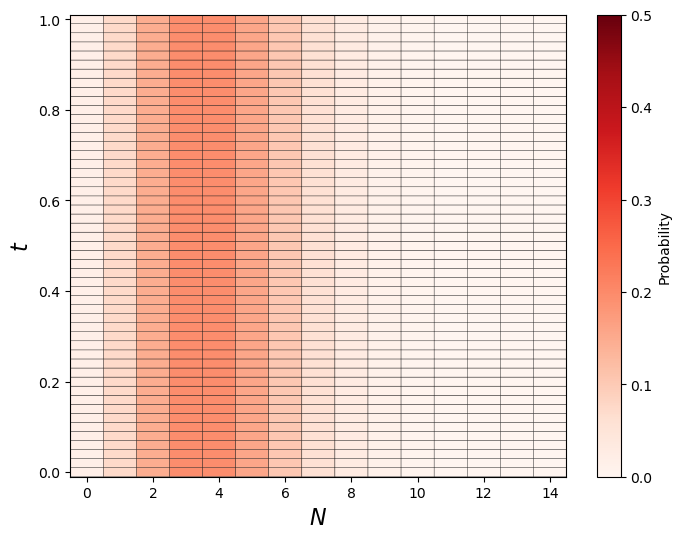

In [12]:
plot_fock_distribution_vs_time(tlist, result.states);

So the fock state distribution is constant, but let's see how the Wigner function of the state evolves in time. To best illustrate the dynamics of the Wigner function we make a short movie that shows the Wigner function from time $t=0$ to the final time of the evolution.

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))


def update(n):
    plot_wigner(result.states[n], fig=fig, ax=ax)
    return ax.artists


anim = animation.FuncAnimation(fig, update, frames=len(result.states),
                               blit=True)

anim.save("animation-kerr-coherent-state.mp4", fps=10, writer="ffmpeg")

plt.close(fig)

In [14]:
display_embedded_video("animation-kerr-coherent-state.mp4")

Isn't that interesting! The dynamics is periodic, and we evolved the state for exactly one period, so that the final state is equal to the initial state.

In between there is interesting stuff going on. For example, after half the period the state ends up in something that looks very much like a cat-state superposition of coherent states!

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))


def update(n):
    plot_wigner(result.states[n], fig=fig, ax=ax)
    return ax.artists


anim = animation.FuncAnimation(
    fig, update, frames=int(len(result.states) / 2 + 1), blit=True
)

anim.save("animation-kerr-coherent-state-half-period.mp4",
          fps=10, writer="ffmpeg")

plt.close(fig)

In [16]:
display_embedded_video("animation-kerr-coherent-state-half-period.mp4")

And indeed, evolving a coherent state $|\alpha\rangle$ for the time $\chi t = \pi$ results in the cat state

$\psi = \frac{1}{\sqrt{2}}\left(e^{i\pi/4}|-i\alpha\rangle + e^{-i\pi/4}|i\alpha\rangle\right)$

(See Walls and Milburn, Quantum Optics, p91)

In [17]:
psi = (
    np.exp(1j * np.pi / 4) * coherent(N, -2.0j)
    + np.exp(-1j * np.pi / 4) * coherent(N, 2.0j)
).unit()

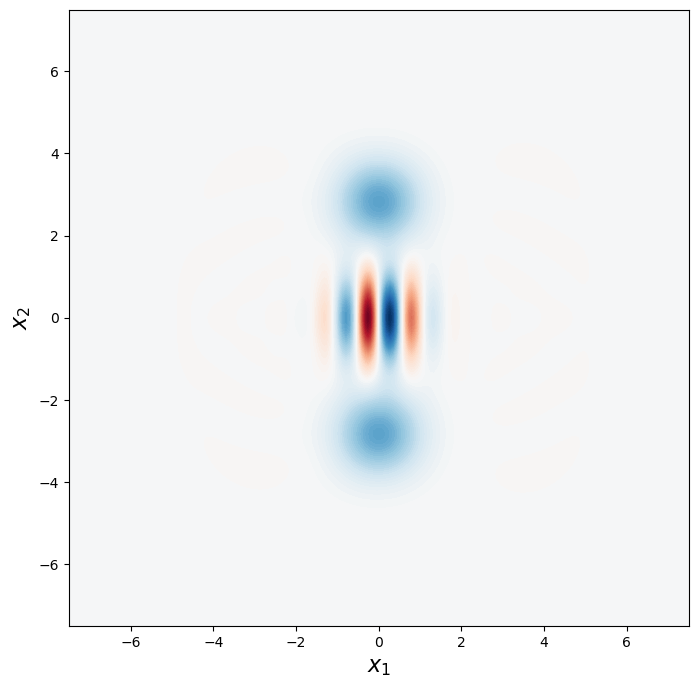

In [18]:
plot_wigner(psi);

### Software versions

In [19]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer

### Acknowledgements

Thanks Sander Konijnenberg for correcting an error in the analytical expression for the Cat state.